# Figure

In [1]:
from pathlib import Path
import sys
root = Path.cwd().resolve().parents[0]
sys.path.insert(0, str(root))

import numpy as np
import data.sphere_torus_utils.torus_data_gen as tdg
import data.sphere_torus_utils.sphere_torus_helpers as sth
import data.sphere_torus_utils.sphere_torus_data_gen as dg

def generate_truncated_torus_data(d=3):
    AMBIENT_DIM = d
    dt = 0.01
    top = 100
    paths = 100

    region1 = paths // 2
    region3 = region1 // 2
    region2 = paths - region1 - region3

    x0 = sth.generateInitialConditions_(paths, random=False)
    x0_lst = [x0[:region1], x0[region1:region1+region2], x0[region1+region2:paths]]
    data_lst = [] 

    for _, _x0 in enumerate(x0_lst):
        data_ = sth.generateData_(_x0, top, dt)

        data_, theta, phi = sth.changetotorus_(data_)
        
        data_ = tdg.map_to_torus_(theta, phi, AMBIENT_DIM)
        data_ = data_.transpose(1, 0, 2)
        data_ = data_[:, :-6, :]

        periodArray = sth.computeFirstRepeatIndexArray_(data_)
        data_ = sth.truncatePath_(data_, periodArray)

        data_lst.append(data_)
    
    return x0_lst, data_lst

def generate_truncated_sphere_data():
    dt = 0.01
    top = 100
    paths = 100

    region1 = paths // 2
    region3 = region1 // 2
    region2 = paths - region1 - region3

    x0 = sth.generateInitialConditions_(paths, random=False)
    x0_lst = [x0[:region1], x0[region1:region1+region2], x0[region1+region2:paths]]
    data_lst = [] 

    for _, _x0 in enumerate(x0_lst):
        data_ = sth.generateData_(_x0, top, dt)
        data_lst.append(data_)

    return data_lst

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D  # noqa

def slice_cmap(base_cmap, lo, hi, n=256):
    base = cm.get_cmap(base_cmap, 1024)
    return colors.LinearSegmentedColormap.from_list(
        f"{base_cmap}_slice_{lo:.2f}_{hi:.2f}",
        base(np.linspace(lo, hi, n))
    )

def kill_small(a, tol=1e-15):
    a = np.asarray(a, dtype=float).copy()
    a[np.abs(a) < tol] = 0.0
    return a

edges = (0.00, 0.5, 0.75, 1.00)
cmaps = [
    slice_cmap("plasma", edges[0], edges[1]),
    slice_cmap("plasma", edges[1], edges[2]),
    slice_cmap("plasma", edges[2], edges[3])
]
x0_lst, torus_data_lst = generate_truncated_torus_data(d=3)
sphere_data_lst = generate_truncated_sphere_data()


/tmp/ipykernel_579296/1855463719.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  base = cm.get_cmap(base_cmap, 1024)


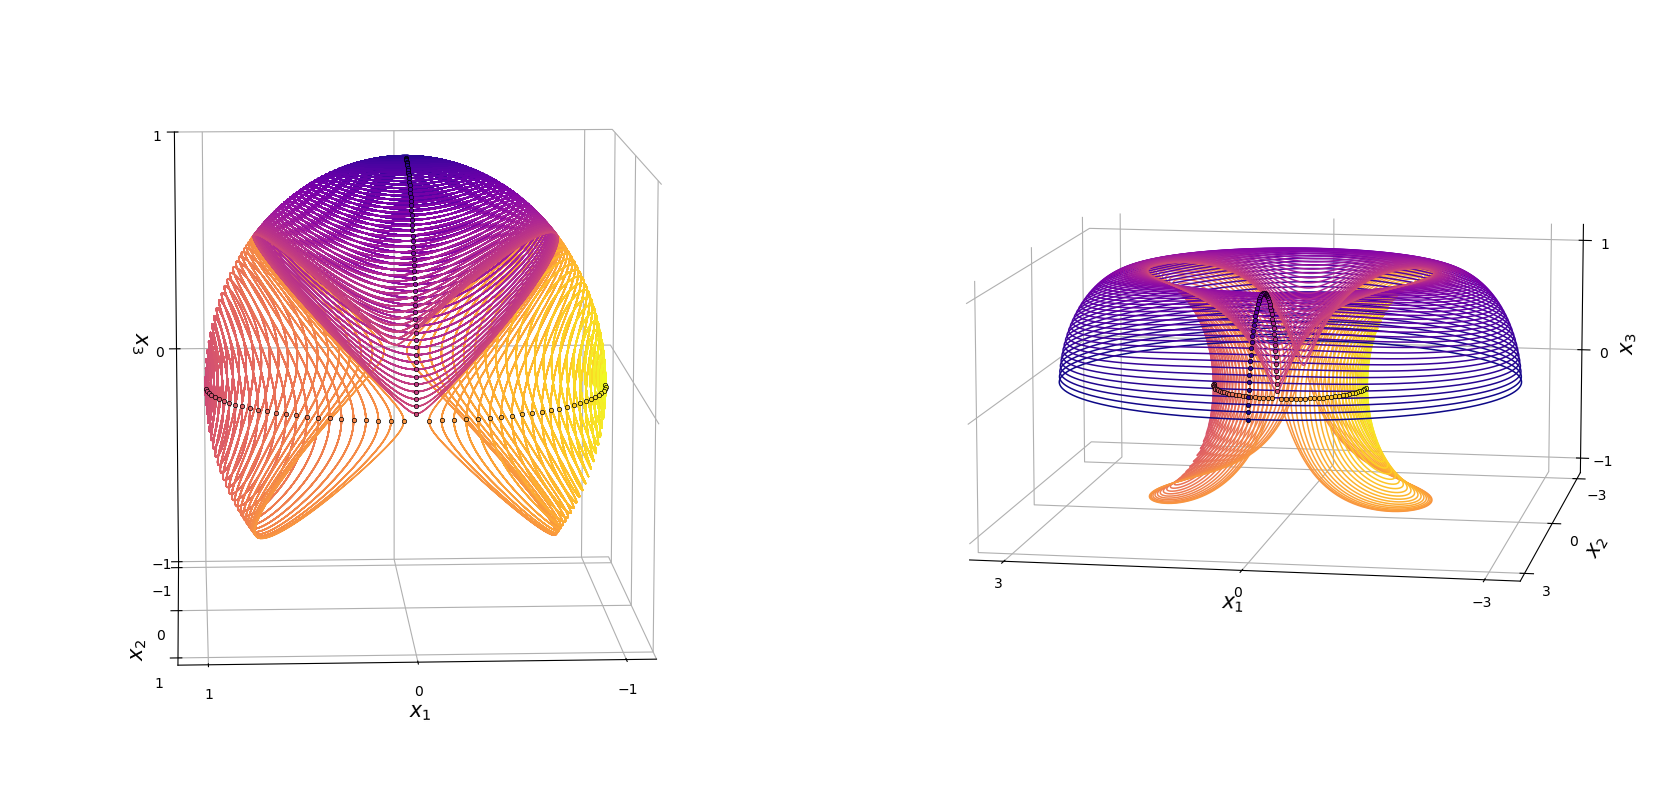

In [3]:
fig = plt.figure(figsize=(18, 8))
gs  = fig.add_gridspec(nrows=1, ncols=2, wspace=0)

"""
    Sphere
"""
ax1 = fig.add_subplot(gs[0], projection="3d")
idx_order = list(reversed(range(len(x0_lst))))
first_band = idx_order[0]

for _i in idx_order:
    _x0, _data = x0_lst[_i], sphere_data_lst[_i]
    cmap = cmaps[_i]
    n_traj = len(_data)
    norm = colors.Normalize(vmin=0, vmax=max(n_traj - 1, 1))

    for _j, jd in enumerate(_data):
        t = norm(_j)
        color = cmap(t)
        j_x0 = _x0[_j]

        jd_plot = kill_small(jd, 1e-14) 
        j_x0    = kill_small(j_x0, 1e-14)

        if _i == first_band:
            ax1.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)
            ax1.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
        else:
            ax1.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
            ax1.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)

ax1.set_box_aspect((1, 1, 1))
ax1.set_xlabel(r"$x_1$", fontsize=15)
ax1.set_ylabel(r"$x_2$", fontsize=15)
ax1.set_zlabel(r"$x_3$", fontsize=15)

ax1.set_xticks([-1, 0, 1])
ax1.set_yticks([-1, 0, 1])
ax1.set_zticks([-1, 0, 1])
ax1.set_zlim([-1, 1])

ax1.xaxis.set_pane_color((1, 1, 1, 0))
ax1.yaxis.set_pane_color((1, 1, 1, 0))
ax1.zaxis.set_pane_color((1, 1, 1, 0))

ax1.view_init(elev=10, azim=87)

"""
    Torus 3D
"""
ax2 = fig.add_subplot(gs[1], projection="3d")

for _i in idx_order:
    _x0, _data = x0_lst[_i], torus_data_lst[_i]
    cmap = cmaps[_i]
    n_traj = len(_data)
    norm = colors.Normalize(vmin=0, vmax=max(n_traj - 1, 1))

    for _j, jd in enumerate(_data):
        t = norm(_j)
        color = cmap(t)
        __, theta, phi = sth.changetotorus_(_x0[_j].reshape(1, 1, -1)) 
        j_x0 = tdg.map_to_torus(theta, phi, 3)[0][0]

        jd_plot = kill_small(jd, 1e-14) 
        j_x0    = kill_small(j_x0, 1e-14)

        if _i == first_band:
            ax2.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)
            ax2.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
        else:
            ax2.plot(jd_plot[:, 0], jd_plot[:, 1], jd_plot[:, 2], color=color, lw=1.1)
            ax2.scatter(j_x0[0], j_x0[1], j_x0[2], color=color, s=10,
                       edgecolors='k', linewidths=0.5)

ax2.set_box_aspect((1, 1, 0.5))
ax2.set_xlabel(r"$x_1$", fontsize=15)
ax2.set_ylabel(r"$x_2$", fontsize=15)
ax2.set_zlabel(r"$x_3$", fontsize=15)

ax2.set_xticks([-3, 0, 3])
ax2.set_yticks([-3, 0, 3])
ax2.set_zticks([-1, 0, 1])

ax2.xaxis.set_pane_color((1, 1, 1, 0))
ax2.yaxis.set_pane_color((1, 1, 1, 0))
ax2.zaxis.set_pane_color((1, 1, 1, 0))

ax2.view_init(elev=10, azim=100)

fig.tight_layout()

fig.savefig('./pics/torus_figure.png', bbox_inches="tight", dpi=600, transparent=True)

# Torus

## validation

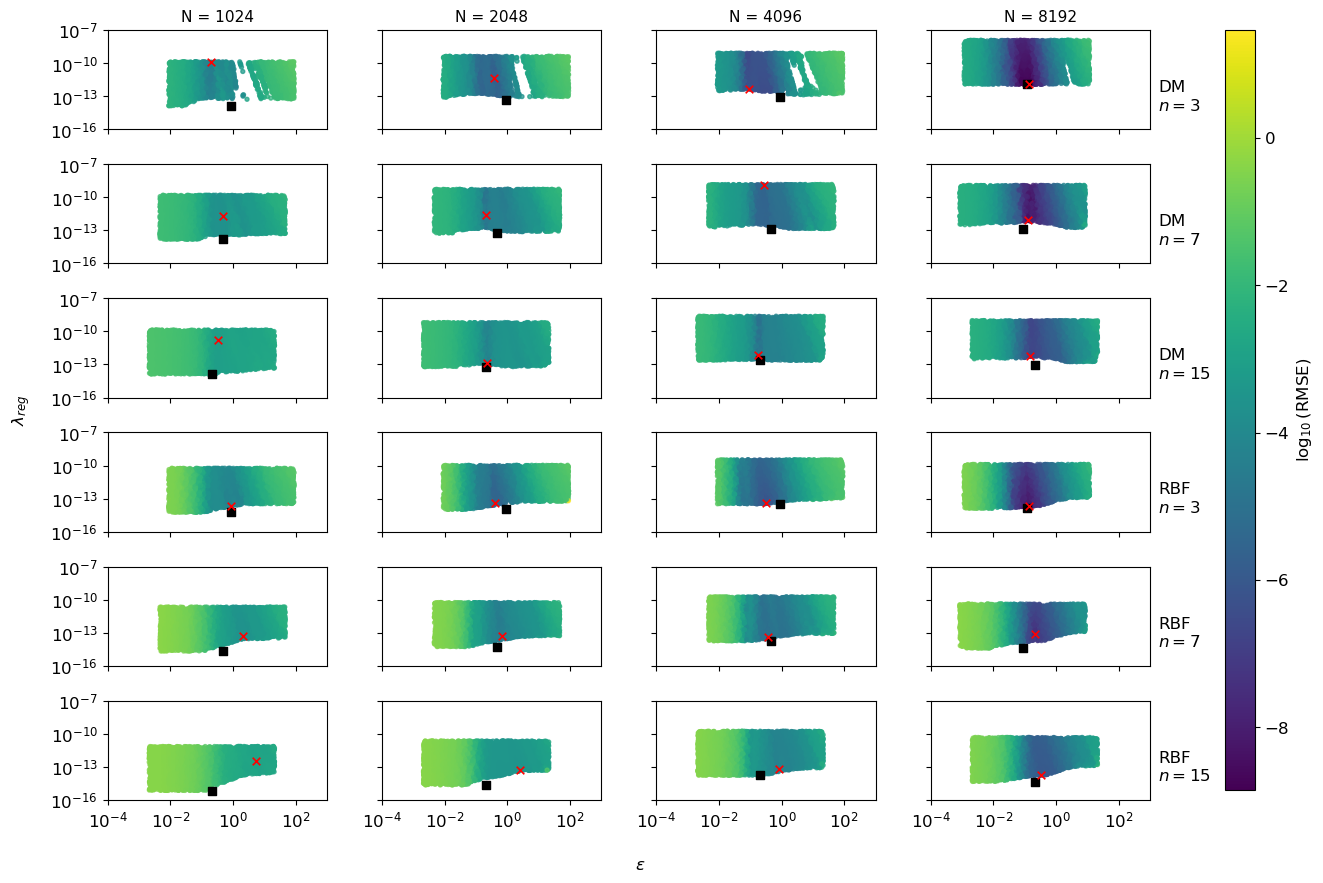

In [4]:
import os
import numpy as np
import polars as pl
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator


devices = 4
modes = ["diffusion", "rbf"]
mode_labels = {"diffusion": "DM", "rbf": "RBF"}
num_points_lst = [1024, 2048, 4096, 8192]
map_type = "skip-connection"
dt = 0.01
d_lst = [3, 7, 15]
plt.rcParams.update({"font.size": 12})

global_min = np.inf
global_max = -np.inf
existing = {} 

for mode in modes:
    for d in d_lst:
        for num_points in num_points_lst:
            fname =  f"/home/jzs6565/diffusion_maps/trained_mdls/torus/torus_{d}d_cv_result_{mode}_{num_points}_{map_type}_dt_{dt}.parquet"
            if not os.path.exists(fname):
                continue
            df = pl.read_parquet(fname)
            existing[(mode, d, num_points)] = df

            rmse = df["rmse"].to_numpy()
            mask = np.isfinite(rmse) & (rmse > 0)
            if not np.any(mask):
                continue
            log_rmse = np.log10(rmse[mask])
            global_min = min(global_min, np.nanmin(log_rmse))
            global_max = max(global_max, np.nanmax(log_rmse))

if not np.isfinite(global_min) or not np.isfinite(global_max):
    raise RuntimeError("No valid RMSE values > 0 found across the provided parquet files.")

nrows = len(modes) * len(d_lst)
ncols = len(num_points_lst)

fig, axs = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(15, 10),
    sharex=False, sharey=False
)

fig.subplots_adjust(right=0.82, wspace=0.25, hspace=0.35)

norm = mpl.colors.Normalize(vmin=global_min, vmax=global_max)
cmap = "viridis"

for i_mode, mode in enumerate(modes):
    for j_d, d in enumerate(d_lst):
        row = len(d_lst) * i_mode + j_d

        for j, num_points in enumerate(num_points_lst):
            ax = axs[row, j]

            key = (mode, d, num_points)
            if key not in existing:
                ax.set_visible(False)
                continue

            cv_results = existing[key]
            eps   = cv_results["epsilon"].to_numpy()
            lam   = cv_results["lambda_reg"].to_numpy()
            eps_c = cv_results["epsilon_c"].to_numpy()[0]
            lam_m = cv_results["lambda_min"].to_numpy()[0]
            rmse  = cv_results["rmse"].to_numpy()

            mask = (
                np.isfinite(rmse) & (rmse > 0) &
                np.isfinite(eps)  & (eps  > 0) &
                np.isfinite(lam)  & (lam  > 0)
            )
            if not np.any(mask):
                ax.set_visible(False)
                continue

            ax.scatter(
                eps[mask],
                lam[mask],
                c=np.log10(rmse[mask]),
                cmap=cmap,
                norm=norm,
                s=8,
                alpha=0.75,
            )

            idx = np.nanargmin(rmse[mask])
            ax.scatter([eps[mask][idx]], [lam[mask][idx]], c="red", marker="x", s=30, linewidths=1.2, zorder=10)
            ax.scatter(eps_c, 10**lam_m, c="black", marker='s', s=30)

            ax.set_xscale("log")
            ax.set_yscale("log")

            ax.set_xlim([10**(-4), 10**(3)])
            ax.set_ylim([10**(-16), 10**(-7)])

            if row == 0:
                ax.set_title(f"N = {num_points}", fontsize=11)

            if j == ncols - 1:
                ax.set_ylabel(f"{mode_labels[mode]}\n$n={d}$", rotation=0, labelpad=6, ha="left")
                ax.yaxis.set_label_position("right")

x0 = fig.subplotpars.right + 0.05
cbar_ax = fig.add_axes([x0, 0.12, 0.02, 0.76])

sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar_ax.set_ylabel(r"$\log_{10}(\mathrm{RMSE})$")


fig.text(0.48, 0.04, r"$\epsilon$", ha="center", fontsize=12)
fig.text(0.06, 0.5, r"$\lambda_{reg}$", va="center", rotation="vertical", fontsize=12)


x_locator = LogLocator(base=10, numticks=3)
y_locator = LogLocator(base=10, numticks=4)

for ax in axs.flat:

    ax.tick_params(
        axis="x",
        which="both",
        bottom=True,
        top=False,
        labelbottom=False
    )
    ax.tick_params(
        axis="y",
        which="both",
        left=True, 
        right=False,
        labelleft=False
    )

    ax.xaxis.set_major_locator(x_locator)
    ax.yaxis.set_major_locator(y_locator)
    ax.minorticks_off()

for r in range(nrows):
    ax = axs[r, 0]
    ax.tick_params(axis="y", which="both", left=True, labelleft=True)
    ax.yaxis.set_major_locator(y_locator)

for c in range(ncols):
    ax = axs[nrows - 1, c]
    ax.tick_params(axis="x", which="both", bottom=True, labelbottom=True)
    ax.xaxis.set_major_locator(x_locator)

# fig.savefig("./pics/torus_cv_results.png", bbox_inches="tight", dpi=600, transparent=True)


## Test

['/home/jzs6565/.conda/envs/dm_env/lib/python39.zip', '/home/jzs6565/.conda/envs/dm_env/lib/python3.9', '/home/jzs6565/.conda/envs/dm_env/lib/python3.9/lib-dynload', '', '/home/jzs6565/.conda/envs/dm_env/lib/python3.9/site-packages']


Text(0.08, 0.5, 'Average RMSE Across Testing Trials')

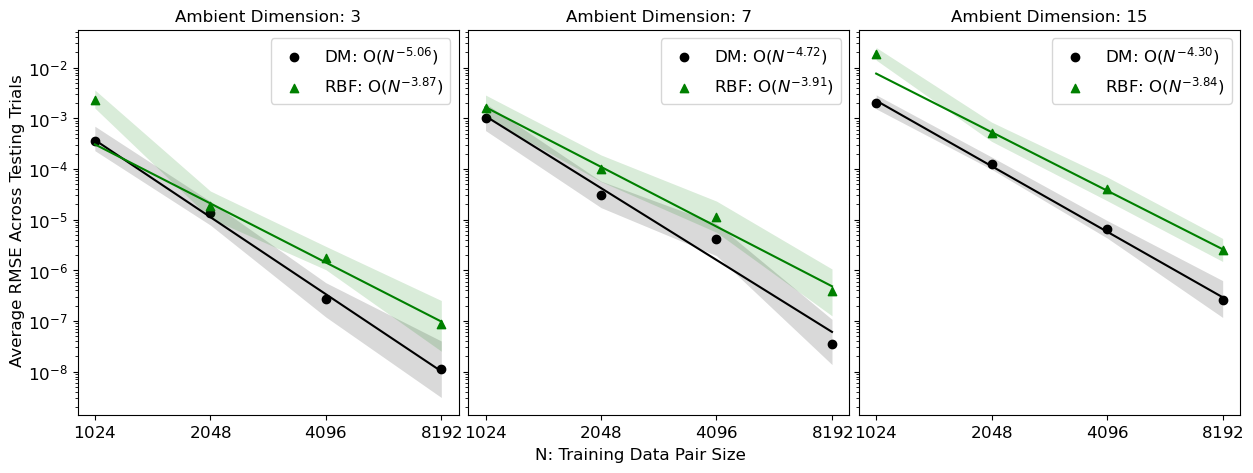

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, FuncFormatter, FixedLocator
# from diffusion_maps import model_dir
import sys
print(sys.path)

def log2_formatter(x, pos):
    return f"$2^{{{int(np.log2(x))}}}$"

num_points_array = [1024, 2048, 4096, 8192]
modes = ["diffusion", "rbf"]
mode_to_label = {"diffusion": "DM", "rbf": "RBF"}
dim_list = [3, 7, 15]
mode_to_color = {"diffusion": "black", "rbf": "green"}
mode_to_marker = {"diffusion": "o", "rbf": "^"}
map_type = "skip-connection"
dt = 0.01

plt.rcParams.update({"font.size": 12})
fig, axs = plt.subplots(1, len(dim_list), figsize=(15, 5), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.025)



for ax, dim in zip(axs, dim_list):
    for mode in modes:
        means, mins, maxs, xs = [], [], [], []

        for num_points in num_points_array:
            try:
                path =  f"/home/jzs6565/diffusion_maps/trained_mdls/torus/torus_{dim}d_test_result_{mode}_{num_points}_{map_type}_dt_{dt}.parquet"
                results = pl.read_parquet(path)
                r = results["rmse"].to_numpy()
                if r.size == 0 or not np.all(np.isfinite(r)):
                    continue

                xs.append(num_points)
                means.append(np.mean(r))
                mins.append(np.min(r))
                maxs.append(np.max(r))
            except Exception:
                # file missing or unreadable: skip silently
                continue

        if len(xs) == 0:
            continue

        # sort by N so the band draws correctly
        if mode == "rbf" and (dim == 3 or dim == 15):
            filt = [1, 2 ,3]
        else:
            filt = [0, 1, 2, 3]
            
        xs = np.array(xs)
        means = np.array(means)
        mins = np.array(mins)
        maxs = np.array(maxs)

        # Power-law fit on means if we have >=2 points
        label_text = mode_to_label[mode]
        if len(xs) >= 2 and np.all(means > 0):
            m, c = np.polyfit(np.log(xs[filt]), np.log(means[filt]), 1)
            fit_y = np.exp(m * np.log(xs) + c)
            line_label = f"{label_text}: O$\\left(N^{{{m:.2f}}}\\right)$"
        else:
            fit_y = None
            line_label = label_text

        # Min–max band
        ax.fill_between(xs, mins, maxs, alpha=0.15, step=None,
                        linewidth=0, color=mode_to_color[mode])

        # Mean points
        ax.scatter(xs, means,
                   color=mode_to_color[mode],
                   marker=mode_to_marker[mode],
                   label=line_label)

        # Fitted trend
        if fit_y is not None:
            ax.plot(xs, fit_y, color=mode_to_color[mode], linewidth=1.5)

    ax.set_title(f"Ambient Dimension: {dim}", fontsize=12)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.set_xticks([2**10, 2**11, 2**12, 2**13])
    ax.set_xticklabels(["$1024$", "$2048$", "$4096$", "$8192$"])
    ax.legend()

fig.text(0.5, 0.02, "N: Training Data Pair Size", ha="center", fontsize=12)
fig.text(
    0.08, 0.5,
    "Average RMSE Across Testing Trials",
    va="center",
    rotation="vertical",
    fontsize=12
)

# plt.savefig("./pics/torus_test_rmse.png", bbox_inches="tight", dpi=600, transparent=True)